In [53]:
import pandas as pd
import numpy as np

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import re
import spacy

from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification
import torch

import openai

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from nltk.corpus import stopwords
from datetime import datetime as dt
from fetch_news import MarketNews

sns.set_style("whitegrid")
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["axes.edgecolor"] = "k"

In [54]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\aungs_tko91wk\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [55]:
MarketNews?

Init signature: MarketNews(api_key)
Docstring:     
Fetches market news for a given stock ticker and index.

Attributes:
    url (str): URL endpoint for news API.
    query (dict): Parameters for API request.
    articles (list): List of fetched articles.
    data (DataFrame): Processed articles in DataFrame format.
    _api_key (str): API key for accessing the news API.
Init docstring: Initializes MarketNews with an API key.
File:           c:\users\aungs_tko91wk\eigen\wip[sentimentanalysis]\fetch_news\news.py
Type:           type
Subclasses:     

In [4]:
ticker = "DIS"
# index = "NYSE"
# api_key = "e6daf7c35aabe62faf71835d24505388"
# base_url = "https://api.markets.sh/api/v1/symbols"

# start = "2022-09-17"
# end = "2023-09-17"

# news = MarketNews(api_key=api_key)

# news.get_news(
#     index,
#     ticker,
#     base_url=base_url,
#     start=start,
#     end=end,
#     limit=10000
# )

In [57]:
headlines = pd.read_csv(f"data/{ticker}_headlines.csv", index_col=0, parse_dates=True)

news_start = headlines.index.min()
news_end = headlines.index.max()

print(f"News start date: {news_start}")
print(f"News end date: {news_end}")
print(f"News timeframe: {(news_end - news_start).days} days")

News start date: 2022-10-06 16:25:00
News end date: 2023-09-14 22:25:20
News timeframe: 343 days


In [56]:
headlines = news.data.copy().iloc[::-1]
headlines = headlines.dropna()
headlines.to_csv("data/")

In [7]:
nlp = spacy.load("en_core_web_sm")
stop_words = stopwords.words("english")

def process_text(text, lower_case, remove_stopwords, stop_words, regex_pattern="[^a-zA-Z\s]"):

    text = re.sub(r'^RT[\s]+', '', text)
    text = re.sub(r'\$\w*', '', text)
    text = re.sub(r'https?://[^\s\n\r]+', '', text)
    text = re.sub(r'https?://[A-Za-z0-9./]+','', text)
    text = re.sub(r'https//[A-Za-z0-9./]+','', text)
    text = text.replace("\n", "")
    text = re.sub('@[\w]+', '', text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    if lower_case:
        text = text.lower()
    text = re.sub(regex_pattern, "", text)
    word_list = text.split()
    word_list = [w for w in word_list if len(w) > 1]

    return " ".join([word for word in word_list if word not in stop_words]) if remove_stopwords \
        else " ".join(word_list)

In [8]:
headlines["processed_text"] = headlines[ticker].apply(
    process_text, lower_case=True, remove_stopwords=True, stop_words=stop_words
)

headlines.head()

,DIS,processed_text
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...


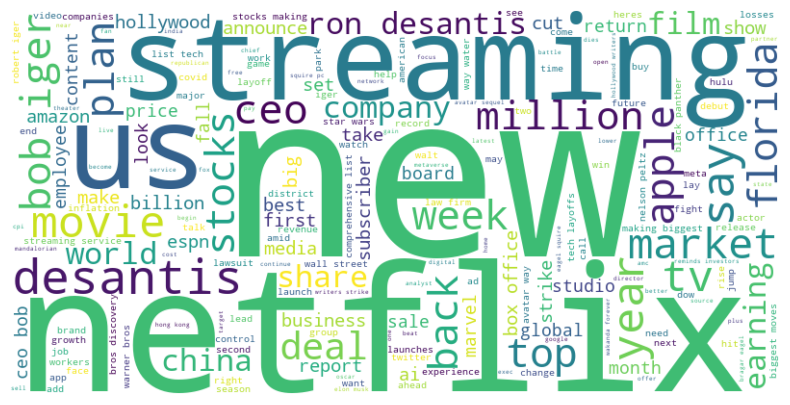

In [9]:
indiv_word_series = headlines["processed_text"].str.split().explode()
all_words = indiv_word_series.to_list()
redundancies = ["disney", "disneys", "stock"]
pruned_words = [w for w in all_words if w not in redundancies]
text_data = " ".join(pruned_words)

wordcloud = WordCloud(width=800, height=400, background_color="white", random_state=88).generate(text_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [10]:
n_words = 5
word_count = indiv_word_series.value_counts()
top_words = word_count[~word_count.index.isin(redundancies)][:n_words]

In [11]:
sentiment_map = {"Neutral": 2, "Negative": 0, "Positive": 1}

In [12]:
def tb_sentiment(text):
    sentiment_analysis = TextBlob(text)
    return sentiment_analysis.sentiment

def tb_extract_scores(text, aspect):
    if aspect == "polarity":
        return tb_sentiment(text)[0]
    elif aspect == "subjectivity":
        return tb_sentiment(text)[1]

def tb_extract_sentiment(polarity):
    return "Positive" if polarity > 0 else "Negative" if polarity < 0 else "Neutral"

headlines_textblob = headlines.copy()
headlines_textblob["textblob_polarity"] = headlines_textblob["processed_text"].apply(tb_extract_scores, aspect="polarity")
headlines_textblob["textblob_subjectivity"] = headlines_textblob["processed_text"].apply(tb_extract_scores, aspect="subjectivity")
headlines_textblob["textblob_sentiment"] = headlines_textblob["textblob_polarity"].apply(tb_extract_sentiment)

In [49]:
headlines_textblob.head()

,DIS,processed_text,textblob_polarity,textblob_subjectivity,textblob_sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,0.000000,0.000000,Neutral
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,0.000000,0.000000,Neutral
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,0.000000,0.000000,Neutral
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,0.175325,0.441558,Positive
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,0.000000,1.000000,Neutral


In [14]:
# tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
# model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [58]:
# def bert_preprocess(text, tokenizer):
#     tokens = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     with torch.no_grad():
#         outputs = model(**tokens)
#     return int(torch.argmax(outputs.logits)) + 1

# def bert_sentiment(logit):
#     return "Positive" if logit > 3 else "Negative" if logit < 3 else "Neutral"

# def bert_extract_sentiment(text, tokenizer):
#     logit = bert_preprocess(text, tokenizer)
#     return bert_sentiment(logit)

# headlines_bert = headlines.copy()
# headlines_bert["bert_sentiment"] = headlines_bert[ticker].apply(bert_extract_sentiment, tokenizer=tokenizer)

headlines_bert = pd.read_csv("data/bert_sentiment.csv", index_col=0, parse_dates=True)

In [59]:
headlines_bert.head()

,DIS,processed_text,bert_sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,Positive
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,Positive
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,Neutral
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,Positive
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,Negative


In [60]:
# vader = SentimentIntensityAnalyzer()

# def vader_extract_scores(text, vader):
#     return vader.polarity_scores(text)

# def vader_get_score(text, vader, score):
#     return vader_extract_scores(text, vader)[score]

# def vader_extract_sentiment(text, vader):
#     score = vader_get_score(text, vader, score="compound")
#     return "Positive" if score > 0.05 else "Negative" if score < -0.05 else "Neutral"

# headlines_vader = headlines.copy()
# headlines_vader["vader_neu"] = headlines_vader["processed_text"].apply(vader_get_score, vader=vader, score="neu")
# headlines_vader["vader_pos"] = headlines_vader["processed_text"].apply(vader_get_score, vader=vader, score="pos")
# headlines_vader["vader_neg"] = headlines_vader["processed_text"].apply(vader_get_score, vader=vader, score="neg")
# headlines_vader["vader_compound"] = headlines_vader["processed_text"].apply(vader_get_score, vader=vader, score="compound")
# headlines_vader["vader_sentiment"] = headlines_vader["processed_text"].apply(vader_extract_sentiment, vader=vader)

headlines_vader = pd.read_csv("data/vader_sentiment.csv", index_col=0, parse_dates=True)
headlines_vader.head()

,DIS,processed_text,vader_neu,vader_pos,vader_neg,vader_compound,vader_sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,1.000,0.000,0.0,0.0000,Neutral
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,1.000,0.000,0.0,0.0000,Neutral
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,1.000,0.000,0.0,0.0000,Neutral
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,1.000,0.000,0.0,0.0000,Neutral
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,0.472,0.528,0.0,0.6808,Positive


In [62]:
# tb_sentiment = headlines_textblob["textblob_sentiment"]
# bert_sentiment = headlines_bert["bert_sentiment"]
# vader_sentiment = headlines_vader["vader_sentiment"]

# sentiments = pd.concat([tb_sentiment, bert_sentiment, vader_sentiment], axis=1)
# sentiment_analysis = pd.concat([headlines, sentiments], axis=1)

# sentiment_analysis

In [27]:
# def gpt_sentiment(headline, api_key, model="gpt-3.5-turbo-16k"):
#     """
#     Function to ask a question to ChatGPT.
    
#     Parameters:
#     - question (str): The question to ask.
#     - model (str): The model to use, default is "gpt-3.5-turbo-16k".
    
#     Returns:
#     - str: The answer from ChatGPT
#     """
    
#     openai.api_key = api_key
    
#     # Create the conversation messages list
#     messages = [
#         {"role": "system", "content": \
#          "You are a helpful assistant who will be performing sentiment analysis. \
#          Your task is to respond with 'Positive', 'Negative', or 'Neutral', and nothing else."},
#         {"role": "user", "content": f"What is the sentiment of the following headline: {headline}"}
#     ]
    
#     # Make the API call
#     response = openai.ChatCompletion.create(
#         model=model,
#         messages=messages,
#     )
    
#     # Extract the assistant's reply
#     answer = response['choices'][0]['message']['content']
#     return answer

In [64]:
# OPENAI_API_KEY = "xxxxxxxxxxxxxxxxxxxxxxxx"

# sentiment_analysis["chatgpt_sentiment"] = sentiment_analysis[ticker].apply(gpt_sentiment, api_key=OPENAI_API_KEY)
sentiment_analysis = pd.read_csv("data/sentiment_analysis.csv", index_col=0, parse_dates=True)
sentiment_analysis.head()

,DIS,processed_text,textblob_sentiment,bert_sentiment,vader_sentiment,chatgpt_sentiment
2022-10-06 16:25:00,JAKKS Pacific: Toy Company On The Mend; Watch ...,jakks pacific toy company mend watch upcoming,Neutral,Positive,Neutral,Neutral
2022-10-06 17:06:00,Disney: Sanderson Sisters Lead The Fourth Quarter,disney sanderson sisters lead fourth quarter,Neutral,Positive,Neutral,Neutral
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,jakks pacific relative undervaluation makes buy,Neutral,Neutral,Neutral,Positive
2022-10-06 23:41:09,ESPN Nears Large New Partnership With DraftKings,espn nears large new partnership draftkings,Positive,Positive,Neutral,Neutral
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,draftkings shares gain report possible espn pa...,Neutral,Negative,Positive,Positive


In [41]:
zoom_in = sentiment_analysis.drop("processed_text", axis=1)
zoom_in[zoom_in["chatgpt_sentiment"] == "Positive"]

,DIS,textblob_sentiment,bert_sentiment,vader_sentiment,chatgpt_sentiment
2022-10-06 23:25:00,JAKKS Pacific: Relative Undervaluation Makes I...,Neutral,Neutral,Neutral,Positive
2022-10-06 23:57:00,DraftKings Shares Gain 8% After Report of Poss...,Neutral,Negative,Positive,Positive
2022-10-07 00:12:00,DraftKings stock jumps on report of partnershi...,Neutral,Positive,Neutral,Positive
2022-10-07 14:23:00,Warner Bros. Discovery: A Hidden Gem,Negative,Positive,Neutral,Positive
2022-10-07 15:12:00,DraftKings Shares Jump After ESPN Partnership ...,Neutral,Negative,Positive,Positive
...,...,...,...,...,...
2023-08-19 15:00:00,Apple Will Finally Pay for Throttling iPhones ...,Neutral,Negative,Negative,Positive
2023-08-22 04:40:42,A virtually unknown conservative singer just r...,Positive,Negative,Positive,Positive
2023-08-27 03:08:04,New Tokyo Disney chief hints at more expansion...,Positive,Negative,Neutral,Positive
2023-09-11 18:24:38,"Disney, Charter settle cable dispute hours bef...",Neutral,Negative,Negative,Positive
